# PLEASE MAKE FOLDER CALLED, ./image/classification/1 until 5, to save the image resulted

1. Design a 3-layer feedforward neural network consisting of a hidden-layer of 10 neurons having logistic activation function and an output softmax layer. Assume a learning rate 𝛼 = 0.01 and decay parameter 𝛽 = 10−6. Use appropriate scaling of input features

In [1]:
import numpy as np
import theano
import theano.tensor as T
from common.time_executor import get_execution_time

# by specifying [10] as the hidden_layer_neuron implies using 1 hidden layer with 10 neurons
# respectively by specifying [100, 100] -> 2 hidden layers each layer 100 neurons


class SoftmaxNeuralNetwork:

    def __init__(self, train_x, train_y, num_features=6, list_of_neuron_on_hidden_layer=list([10]), decay=1e-6,
                 verbose=True):

        self.train_x = train_x
        self.train_y = train_y
        self.verbose = verbose

        self.num_train_data = len(train_x)

        self.train_cost = []
        self.train_prediction = []
        self.train_exec_time = []

        self.test_prediction = []

        weights = []
        biases = []

        # first layer which connect to the input layer
        weights.append(
            self.init_weight(len(train_x[0]), list_of_neuron_on_hidden_layer[0]))
        biases.append(
            self.init_bias(list_of_neuron_on_hidden_layer[0]))

        previous_layer = list_of_neuron_on_hidden_layer[0]

        for layer in range(1, len(list_of_neuron_on_hidden_layer)):
            weights.append(
                self.init_weight(previous_layer, list_of_neuron_on_hidden_layer[layer]))

            biases.append(
                self.init_bias(list_of_neuron_on_hidden_layer[layer]))
            previous_layer = list_of_neuron_on_hidden_layer[layer]

        # for output layer
        weights.append(
            self.init_weight(previous_layer, num_features)
        )

        biases.append(
            self.init_bias(num_features)
        )

        # construct neural network

        layers = []

        x_input = T.matrix('X')
        y_output = T.matrix('Y')

        prev_input = x_input

        for i in range(len(weights)-1):
            calculation = T.nnet.sigmoid(T.dot(prev_input, weights[i]) + biases[i])
            layers.append(calculation)
            prev_input = calculation

        # last output layer, use softmax function
        calculation = T.nnet.softmax(T.dot(prev_input, weights[len(weights)-1]) +
                                     biases[len(biases) - 1])
        layers.append(calculation)

        y_prediction = T.argmax(calculation, axis=1)

        sum_sqr_weights = T.sqr(weights[0])

        for i in range(1, len(weights)):
            sum_sqr_weights += T.sum(T.sqr(weights[i]))

        cost = T.mean(T.nnet.categorical_crossentropy(calculation, y_output)) + decay*T.sum(sum_sqr_weights)
        params = list(weights+biases)
        updates = self.sgd(cost=cost, params=params)

        self.computation = theano.function(
            inputs=[x_input, y_output],
            updates=updates,
            outputs=cost
        )

        self.prediction = theano.function(
            inputs=[x_input],
            outputs=y_prediction
        )

        return

    def init_bias(self, n):
        return theano.shared(np.zeros(n), theano.config.floatX)

    def init_weight(self, n_in, n_out, is_logistic_function=False):

        weight = np.random.uniform(
            size=(n_in, n_out),
            low=-np.sqrt(6. / (n_in + n_out)),
            high=np.sqrt(6. / (n_in + n_out)),
        )

        if is_logistic_function:
            weight = weight*4

        return theano.shared(weight, theano.config.floatX)

    def sgd(self, cost, params, lr=0.01):

        # return list of gradients
        grads = T.grad(cost=cost, wrt=params)

        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - g * lr])
        return updates

    def reshuffle_train_data(self):

        id_to_random = np.arange(self.num_train_data)
        np.random.shuffle(id_to_random)
        return self.train_x[id_to_random], self.train_y[id_to_random]

    def start_train(self, test_x, test_y, epochs=1000, batch_size=100):
        
        current_execution_time = 0
        
        for i in range(epochs):

            self.train_x, self.train_y = self.reshuffle_train_data()

            prediction_batch = []

            cost, exec_time = get_execution_time(self.start_one_iter_func, batch_size, prediction_batch)

            # predictions of train data
            prediction = np.mean(prediction_batch)
            
            self.train_cost.append(cost/(self.num_train_data/batch_size))
            self.train_prediction.append(prediction)
            
            current_execution_time += exec_time
            
            self.train_exec_time.append(current_execution_time)

            print_verbose = (i % 5*batch_size == 0 or i == epochs-1) and self.verbose

            self.start_test(test_x=test_x, test_y=test_y, print_verbose=print_verbose)

            if print_verbose:

                print ('execution_time: %s epoch: %d, train cost: %s, train predictions: %s \n' %
                       (np.sum(self.train_exec_time), i, cost, prediction))
                print('------------------------------------\n')

    def start_one_iter_func(self, batch_size, prediction_batch):

        cost = 0

        for cnt in range(0, len(self.train_x), batch_size):

            end = cnt + batch_size

            if end > len(self.train_x):
                end = len(self.train_x)

            train_x_batch, first_exec_time = get_execution_time(lambda: self.train_x[cnt:end])
            train_y_batch, second_exec_time = get_execution_time(lambda: self.train_y[cnt:end])

            # print ("first_exec_time: %d, second_exec_time: %s \n" % (first_exec_time, second_exec_time))

            cost += self.computation(train_x_batch, train_y_batch)
            # prediction = self.prediction(self.train_x)
            # predict_in_percentage = np.mean(np.argmax(self.train_y, axis=1) == prediction)
            # prediction_batch.append(predict_in_percentage)

        return cost

    def start_test(self, test_x, test_y, print_verbose):

        prediction = self.prediction(test_x)

        predict_in_percentage = np.mean(np.argmax(test_y, axis=1) == prediction)
        self.test_prediction.append(predict_in_percentage)

        if print_verbose:
            print ('test predictions: %s \n' % predict_in_percentage)

    def get_train_result(self):

        return self.train_cost, self.train_prediction, self.train_exec_time[len(self.train_exec_time)-1], self.train_exec_time

    def get_test_result(self):

        return self.test_prediction


Above code is the class to instanstiate the softmax neural network, Below is the implementation of data preprocessing

In [6]:
import pandas as pd
import numpy as np


class DataCollector:

    def __init__(self):
        self.df_train = pd.read_csv("./data/sat_train.txt", delimiter=' ')
        self.df_test = pd.read_csv("./data/sat_test.txt", delimiter=' ')

        # change the index
        self.df_train.columns = range(self.df_train.shape[1])
        self.df_test.columns = range(self.df_test.shape[1])

        self.x_train = self.df_train[range(36)]
        self.y_train = self.df_train[36]

        self.x_test = self.df_test[range(36)]
        self.y_test = self.df_test[36]

        self.x_min_train = self.x_train.min()
        self.x_max_train = self.x_train.max()

        self.x_min_test = self.x_test.min()
        self.x_max_test = self.x_test.max()

        return

    def get_train_data(self):

        return self.normalize_data(self.x_max_train, self.x_min_train, self.x_train), \
               self.one_hot_encoding_data(self.y_train)

    def get_test_data(self):

        return self.normalize_data(self.x_max_test, self.x_min_test, self.x_test),\
               self.one_hot_encoding_data(self.y_test)

    def one_hot_encoding_data(self, df, limit_number=6):

        # in this case data 6 is missing so, 7 we assume to be 6
        df[df == 7] = 6
        df_return = np.zeros((df.shape[0], limit_number))
        df_return[np.arange(df.shape[0]), df - 1] = 1
        return df_return

    def normalize_data(self, max_value, min_value, value):
        return (value - min_value)/(max_value-min_value)


As there is a need to calculate the execution time of giv
en function, hence, helper function to calculate the execution time is developed

As the helper class to do plotting stuff, we create another class to do such task.

In [7]:
import timeit

import matplotlib.pyplot as plt


class DataVisualization:

    def __init__(self):
        return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name):
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()
def get_execution_time(func, *args):
    start_time = timeit.default_timer()
    result = func(*args)
    elapsed = timeit.default_timer() - start_time
    return result, elapsed

In [8]:
import matplotlib.pyplot as plt


class DataVisualizationWithLabels:

    def __init__(self):
        return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):
        plt.figure()
        
        for cnt in range(len(labels)):
            plt.plot(list_x_point[cnt], list_y_point[cnt], label=labels[cnt])
            
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()

Start training the simple multi layer softmax neural network

test predictions: 0.428714357179 

execution_time: 0.0133180618286 epoch: 0, train cost: 240.912460441, train predictions: nan 

------------------------------------

test predictions: 0.43971985993 

execution_time: 0.269318580627 epoch: 5, train cost: 231.823906519, train predictions: nan 

------------------------------------

test predictions: 0.527263631816 

execution_time: 0.857487201691 epoch: 10, train cost: 224.549381128, train predictions: nan 

------------------------------------

test predictions: 0.627813906953 

execution_time: 1.81318116188 epoch: 15, train cost: 215.706769134, train predictions: nan 

------------------------------------

test predictions: 0.653326663332 

execution_time: 3.11807250977 epoch: 20, train cost: 204.354183793, train predictions: nan 

------------------------------------

test predictions: 0.727363681841 

execution_time: 4.78156352043 epoch: 25, train cost: 191.123208495, train predictions: nan 

------------------------------------

tes

test predictions: 0.802901450725 

execution_time: 453.666022062 epoch: 255, train cost: 69.6193197925, train predictions: nan 

------------------------------------

test predictions: 0.8024012006 

execution_time: 471.48842597 epoch: 260, train cost: 69.4668981405, train predictions: nan 

------------------------------------

test predictions: 0.8024012006 

execution_time: 489.652633905 epoch: 265, train cost: 69.3854700808, train predictions: nan 

------------------------------------

test predictions: 0.802901450725 

execution_time: 508.165846825 epoch: 270, train cost: 69.1573613699, train predictions: nan 

------------------------------------

test predictions: 0.803901950975 

execution_time: 527.015657902 epoch: 275, train cost: 68.8711749583, train predictions: nan 

------------------------------------

test predictions: 0.80340170085 

execution_time: 546.200940609 epoch: 280, train cost: 68.6906913081, train predictions: nan 

------------------------------------

test

test predictions: 0.812406203102 

execution_time: 1799.83662033 epoch: 510, train cost: 64.373231406, train predictions: nan 

------------------------------------

test predictions: 0.811905952976 

execution_time: 1835.00486732 epoch: 515, train cost: 64.2235493675, train predictions: nan 

------------------------------------

test predictions: 0.811905952976 

execution_time: 1870.50109315 epoch: 520, train cost: 64.2907142277, train predictions: nan 

------------------------------------

test predictions: 0.812406203102 

execution_time: 1906.32450962 epoch: 525, train cost: 64.0421563041, train predictions: nan 

------------------------------------

test predictions: 0.812406203102 

execution_time: 1942.47893739 epoch: 530, train cost: 64.0418595258, train predictions: nan 

------------------------------------

test predictions: 0.811405702851 

execution_time: 1978.95511031 epoch: 535, train cost: 63.9534698553, train predictions: nan 

------------------------------------


test predictions: 0.817408704352 

execution_time: 4004.04587793 epoch: 765, train cost: 62.0103374629, train predictions: nan 

------------------------------------

test predictions: 0.820910455228 

execution_time: 4055.61079264 epoch: 770, train cost: 61.8994442259, train predictions: nan 

------------------------------------

test predictions: 0.821410705353 

execution_time: 4107.49102664 epoch: 775, train cost: 61.9059621794, train predictions: nan 

------------------------------------

test predictions: 0.818909454727 

execution_time: 4159.68358445 epoch: 780, train cost: 61.8905906231, train predictions: nan 

------------------------------------

test predictions: 0.819909954977 

execution_time: 4212.19959188 epoch: 785, train cost: 61.8268450246, train predictions: nan 

------------------------------------

test predictions: 0.819409704852 

execution_time: 4265.03957748 epoch: 790, train cost: 61.7544228075, train predictions: nan 

------------------------------------

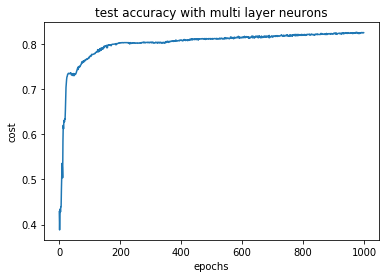

In [10]:
data_visualization = DataVisualization()
data_collector = DataCollector()

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

batch_size = 32
epochs = 1000
decay = 1e-6
list_neurons = [10]

softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y,
                                  list_of_neuron_on_hidden_layer=list_neurons, decay=decay)
softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)


cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
prediction_test = softmax_nn.get_test_result()
    
%matplotlib inline

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=prediction_test,
    x_label="epochs", y_label="cost",
    title="test accuracy with multi layer neurons",
    figure_name="./image/classification/1/multilayer_neurons.png"
)

2.Find the optimal batch size for mini-batch gradient descent while training the neural network by evaluating the performances for different batch sizes. Set this as the batch size for the rest of the experiments

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network for each batch size. Limit search space to:{4,8,16,32,64}. 

train with batch size 4, 8, 16, 32 ,64

execution_time: 84.4313213825 
execution_time: 42.9674921036 
execution_time: 25.8542921543 
execution_time: 14.5100786686 
execution_time: 8.52569031715 


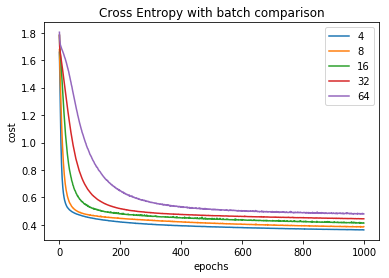

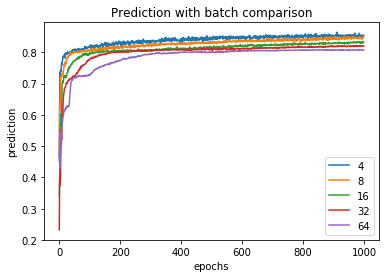

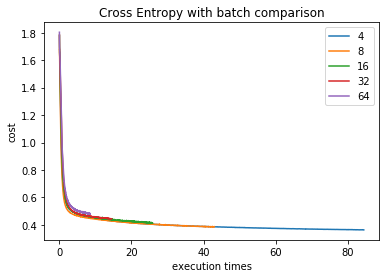

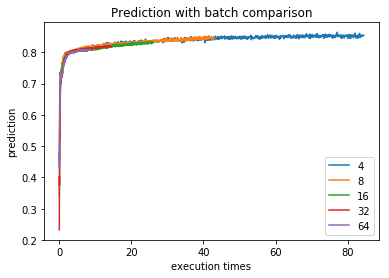

In [32]:
data_visualization = DataVisualizationWithLabels()
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

# number_data = train_x.shape[0]
list_batch = [4, 8, 16, 32, 64]
list_execution_time = []

epochs = 1000

costs = []
predictions = []
list_exec_times = []

list_execution_time = []

for batch in list_batch:
    
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[10], verbose=False)
    softmax_nn.start_train(batch_size=batch, test_x=test_x, test_y=test_y, epochs=epochs)

    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    costs.append(cost_train)
    predictions.append(prediction_test)
    list_exec_times.append(list_exec_time)
    
    list_execution_time.append(exec_time)
    print "execution_time: %s " % exec_time
    
%matplotlib inline

list_x_point = []
for cnt in range(len(list_batch)):
    list_x_point.append(range(epochs))

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=costs,
    x_label="epochs", y_label="cost",
    title="Cross Entropy with batch comparison",
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=list_batch
)

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=predictions,
    x_label="epochs", 
    y_label="prediction", 
    title="Prediction with batch comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=list_batch
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=costs,
    x_label="execution times", y_label="cost",
    title="Cross Entropy with batch comparison",
    figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png",
    labels=list_batch
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=predictions,
    x_label="execution times", 
    y_label="prediction", 
    title="Prediction with batch comparison", 
    figure_name="./image/classification/2/"+str(batch)+"_prediction.png",
    labels=list_batch
)

b) Plot the time taken to update parameters of the network for different batch sizes.

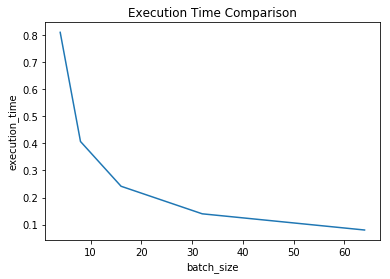

In [30]:
%matplotlib inline
data_visualization = DataVisualization()

data_visualization.show_plot(
    list_x_point=list_batch, list_y_point=list_execution_time,
    x_label="batch_size", y_label="execution_time", title="Execution Time Comparison", 
    figure_name="./image/classification/2/execution_time_comparison.png",
    labels=[]
)

c) State the rationale for selecting the optimal batch size.

16 batch size, since it give a decent result with decent execution time

3.Find the optimal number of hidden neurons for the 3-layer network designed in part (2). Set this number of neurons in hidden layer for the rest of the experiments.

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network at hidden-layer neurons. Limit the search space to the set:
{5,10,15,20,25}.

execution_time: 2.05790758133 
execution_time: 2.57228398323 
execution_time: 2.61893939972 
execution_time: 2.90914535522 
execution_time: 2.71590542793 


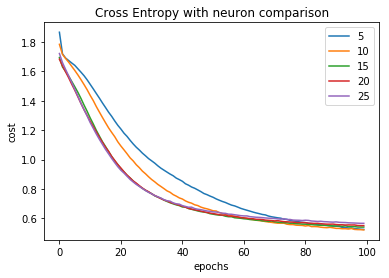

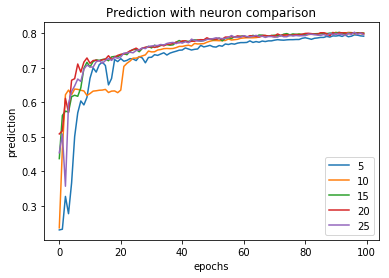

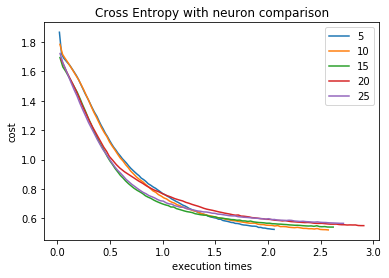

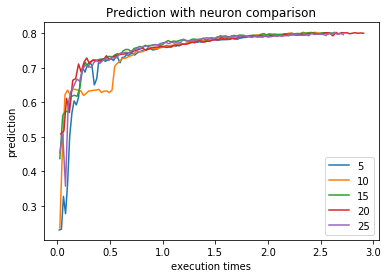

In [62]:
# visualize
data_visualization = DataVisualizationWithLabels()

data_collector = DataCollector()

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

list_neurons = [5, 10, 15, 20, 25]
batch_size = 16
epochs = 100

costs = []
predictions = []
list_exec_times = []

list_execution_time = []


for neurons in list_neurons:

    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[neurons], verbose=False)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    costs.append(cost_train)
    predictions.append(prediction_test)  
    list_exec_times.append(list_exec_time)
    
    list_execution_time.append(exec_time)
    
    print "execution_time: %s " % exec_time

%matplotlib inline

list_x_point = []
for cnt in range(len(list_neurons)):
    list_x_point.append(range(epochs))

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=costs,
    x_label="epochs", y_label="cost", 
    title="Cross Entropy with neuron comparison", 
    figure_name="./image/classification/23neuron_comparison_cross_entropy.png",
    labels=list_neurons
)

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=predictions,
    x_label="epochs", y_label="prediction", 
    title="Prediction with neuron comparison", 
    figure_name="./image/classification/3/neuron_comparison_prediction.png",
    labels=list_neurons
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=costs,
    x_label="execution times", y_label="cost", 
    title="Cross Entropy with neuron comparison", 
    figure_name="./image/classification/3/neuron_comparison_cross_entropy_exec_times.png",
    labels=list_neurons
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=predictions,
    x_label="execution times", y_label="prediction", 
    title="Prediction with neuron comparison", 
    figure_name="./image/classification/3/neuron_comparison_prediction_exec_times.png",
    labels=list_neurons
)

b) Plot the time to update parameters of the network for different number of hiddenlayer
neurons

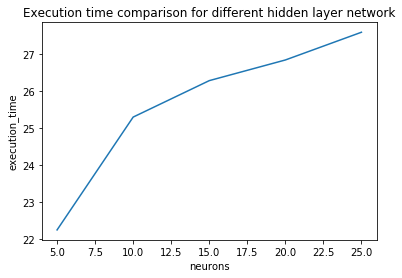

In [28]:
%matplotlib inline
data_visualization = DataVisualization()
data_visualization.show_plot(
    list_x_point=list_neurons, list_y_point=list_execution_time,
    x_label="neurons", y_label="execution_time", title="Execution time comparison for different hidden layer network",
    figure_name="./image/classification/3/hidden_layer_exec_time_comparison.png"
)

c) State the rationale for selecting the optimal number of hidden neurons

15 number of neurons, since 5,10 neurons lead low accuracy during 30 epochs, but the rest of neurons perform quite same, so we choose the less complex neural structure.

4.Find optimal decay parameter for the 3-layer network designed in part (3)

a) Plot the training error against number of epochs for the 3-layer network for
different values of decay parameter in search space{0, 10−3
,10−6
, 10−9
,10−12}.
b) Plot the test accuracy against the different values of decay parameter.

decay: 0 

decay: 0.001 

decay: 1e-06 

decay: 1e-09 

decay: 1e-12 



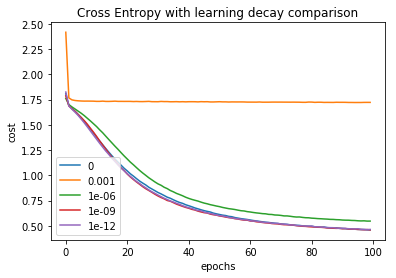

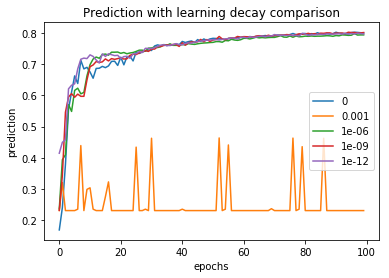

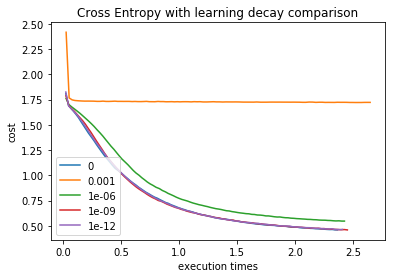

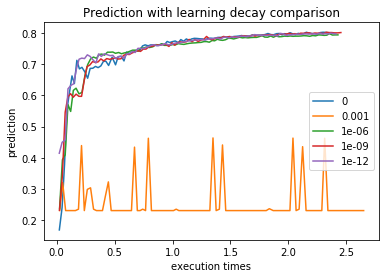

In [71]:
data_visualization = DataVisualizationWithLabels()
data_collector = DataCollector()

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

learning_decays = [0, 1e-3, 1e-6, 1e-9, 1e-12]
batch_size = 16
epochs = 100
list_neurons_hidden_layer = [10]

costs = []
predictions = []
list_exec_times = []

list_execution_time = []

for decay in learning_decays:
    print "decay: %s \n" % decay
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=list_neurons_hidden_layer, 
                                      verbose=False, decay=decay)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, 
                           test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result() 
    
    costs.append(cost_train)
    predictions.append(prediction_test)  
    list_exec_times.append(list_exec_time)
    
    list_execution_time.append(exec_time)
    
%matplotlib inline
list_x_point = []
for cnt in range(len(learning_decays)):
    list_x_point.append(range(epochs))

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=costs,
    x_label="epochs", y_label="cost", 
    title="Cross Entropy with learning decay comparison", 
    figure_name="./image/classification/4/learning_decay_comparison_cross_entropy.png",
    labels=learning_decays
)

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=predictions,
    x_label="epochs", y_label="prediction", 
    title="Prediction with learning decay comparison", 
    figure_name="./image/classification/4/learning_decay_comparison_prediction.png",
    labels=learning_decays
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=costs,
    x_label="execution times", y_label="cost", 
    title="Cross Entropy with learning decay comparison", 
    figure_name="./image/classification/4/learning_decay_comparison_cross_entropy_exec_times.png",
    labels=learning_decays
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=predictions,
    x_label="execution times", y_label="prediction", 
    title="Prediction with learning decay comparison", 
    figure_name="./image/classification/4/learning_decay_comparison_prediction_exec_times.png",
    labels=learning_decays
)


c) State the rationale for selecting the optimal decay parameter. 

Learing decay causing the cost function to be adjusted based on the weight, which means more fluctuation happened, such that the best learning decay is the one which give us the less fluctuate result.

5. After you’re done with the 3-layer network, design a 4-layer network with two hiddenlayers,each consisting of 10 neurons with logistic activation functions, batch size of 32 and decay parameter 10-6.

a) Plot the train and test accuracy of the 4-layer network.
b) Compare and comment on the performances on 3-layer and 4-layer networks.

execution time: 17.9944345951 

execution time: 13.6042485237 



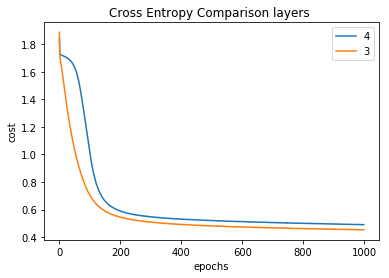

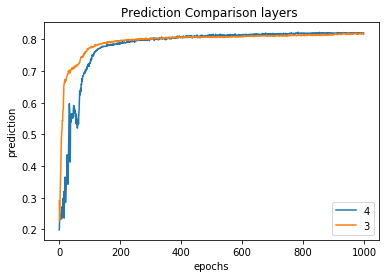

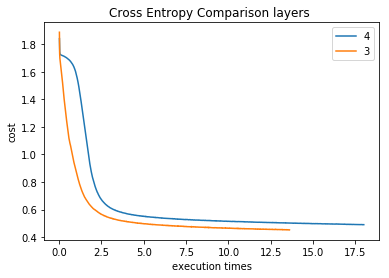

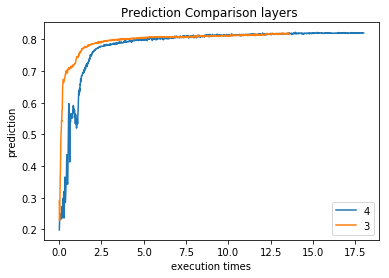

In [86]:
data_visualization = DataVisualizationWithLabels()

data_collector = DataCollector()

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

batch_size=32
epochs=1000
decay = 1e-6

costs = []
predictions = []
list_exec_times = []
list_execution_time = []

list_layer = [4,3]
list_neurons_on_each_hidden_layer = [[10, 10], [10]]

for list_neurons in list_neurons_on_each_hidden_layer:
    
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y,
                                      list_of_neuron_on_hidden_layer=list_neurons, verbose=False,
                                      decay=decay   
                                     )
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result() 
    
    costs.append(cost_train)
    predictions.append(prediction_test)
    
    list_exec_times.append(list_exec_time)
    list_execution_time.append(exec_time)
    
    print "execution time: %s \n" % exec_time
    
%matplotlib inline
list_x_point = []
for cnt in range(len(list_layer)):
    list_x_point.append(range(epochs))

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=costs,
    x_label="epochs", y_label="cost", title="Cross Entropy Comparison layers ",
    figure_name="./image/classification/5/4_3_layer_cross_entropy.png",
    labels=list_layer
)

data_visualization.show_plot(
    list_x_point=list_x_point, list_y_point=predictions,
    x_label="epochs", y_label="prediction", title="Prediction Comparison layers ",
    figure_name="./image/classification/5/4_3_layer_prediction.png",
    labels=list_layer
)


data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=costs,
    x_label="execution times", y_label="cost", title="Cross Entropy Comparison layers ",
    figure_name="./image/classification/5/4_3_layer_cross_entropy_exec_time.png",
    labels=list_layer
)

data_visualization.show_plot(
    list_x_point=list_exec_times, list_y_point=predictions,
    x_label="execution times", y_label="prediction", title="Prediction Comparison layers ",
    figure_name="./image/classification/5/4_3_layer_prediction_exec_time.png",
    labels=list_layer
)

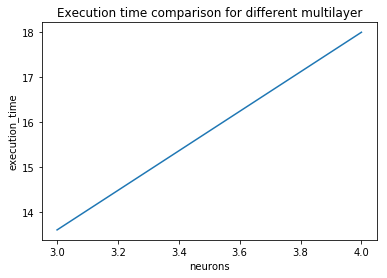

In [87]:
%matplotlib inline

data_visualization = DataVisualization()
data_visualization.show_plot(
    list_x_point=list_layer, list_y_point=list_execution_time,
    x_label="neurons", y_label="execution_time", title="Execution time comparison for different multilayer",
    figure_name="./image/classification/3/hidden_layer_exec_time_comparison.png"
)

b) Compare and comment on the performances on 3-layer and 4-layer networks.

the performance of 3 layer with 4 layer is quite similar therefore we choose 3 layer neurons since it gives similar performance with less complex model

The best neural network structure is with 3 hidden layer, since it is less complex and give the same result with the 4 hidden layer model.

# ADDITIONAL INVESTIGATION 

single layer neural network.

In [1]:
import numpy as np
import theano
import theano.tensor as T
from common.time_executor import get_execution_time

# by specifying [10] as the hidden_layer_neuron implies using 1 hidden layer with 10 neurons
# respectively by specifying [100, 100] -> 2 hidden layers each layer 100 neurons


class SingleLayerSoftmax:

    def __init__(self, train_x, train_y, num_features=6, decay=1e-6,
                 verbose=True):

        self.train_x = train_x
        self.train_y = train_y
        self.verbose = verbose

        self.num_train_data = len(train_x)

        self.train_cost = []
        self.train_prediction = []
        self.train_exec_time = []

        self.test_prediction = []

        weights = []
        biases = []

        # first layer which connect to the input layer
        weights.append(
            self.init_weight(len(train_x[0]), num_features))
        biases.append(
            self.init_bias(num_features))
        
        x_input = T.matrix('X')
        y_output = T.matrix('Y')

        calculation = T.nnet.softmax(T.dot(x_input, weights[len(weights)-1]) +
                                     biases[len(biases) - 1])
        
        y_prediction = T.argmax(calculation, axis=1)

        sum_sqr_weights = T.sqr(weights[0])

        for i in range(1, len(weights)):
            sum_sqr_weights += T.sum(T.sqr(weights[i]))

        cost = T.mean(T.nnet.categorical_crossentropy(calculation, y_output)) + decay*T.sum(sum_sqr_weights)
        params = list(weights+biases)
        updates = self.sgd(cost=cost, params=params)

        self.computation = theano.function(
            inputs=[x_input, y_output],
            updates=updates,
            outputs=cost
        )

        self.prediction = theano.function(
            inputs=[x_input],
            outputs=y_prediction
        )

        return

    def init_bias(self, n):
        return theano.shared(np.zeros(n), theano.config.floatX)

    def init_weight(self, n_in, n_out, is_logistic_function=False):

        weight = np.random.uniform(
            size=(n_in, n_out),
            low=-np.sqrt(6. / (n_in + n_out)),
            high=np.sqrt(6. / (n_in + n_out)),
        )

        if is_logistic_function:
            weight = weight*4

        return theano.shared(weight, theano.config.floatX)

    def sgd(self, cost, params, lr=0.01):

        # return list of gradients
        grads = T.grad(cost=cost, wrt=params)

        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - g * lr])
        return updates

    def reshuffle_train_data(self):

        id_to_random = np.arange(self.num_train_data)
        np.random.shuffle(id_to_random)
        return self.train_x[id_to_random], self.train_y[id_to_random]

    def start_train(self, test_x, test_y, epochs=1000, batch_size=100):
        
        current_execution_time = 0
        
        for i in range(epochs):

            self.train_x, self.train_y = self.reshuffle_train_data()

            prediction_batch = []

            cost, exec_time = get_execution_time(self.start_one_iter_func, batch_size, prediction_batch)

            # predictions of train data
            prediction = np.mean(prediction_batch)
            
            self.train_cost.append(cost/(self.num_train_data/batch_size))
            self.train_prediction.append(prediction)
            
            current_execution_time += exec_time
            
            self.train_exec_time.append(current_execution_time)

            print_verbose = (i % 5*batch_size == 0 or i == epochs-1) and self.verbose

            self.start_test(test_x=test_x, test_y=test_y, print_verbose=print_verbose)

            if print_verbose:

                print ('execution_time: %s epoch: %d, train cost: %s, train predictions: %s \n' %
                       (np.sum(self.train_exec_time), i, cost, prediction))
                print('------------------------------------\n')

    def start_one_iter_func(self, batch_size, prediction_batch):

        cost = 0

        for cnt in range(0, len(self.train_x), batch_size):

            end = cnt + batch_size

            if end > len(self.train_x):
                end = len(self.train_x)

            train_x_batch, first_exec_time = get_execution_time(lambda: self.train_x[cnt:end])
            train_y_batch, second_exec_time = get_execution_time(lambda: self.train_y[cnt:end])

            # print ("first_exec_time: %d, second_exec_time: %s \n" % (first_exec_time, second_exec_time))

            cost += self.computation(train_x_batch, train_y_batch)
            # prediction = self.prediction(self.train_x)
            # predict_in_percentage = np.mean(np.argmax(self.train_y, axis=1) == prediction)
            # prediction_batch.append(predict_in_percentage)

        return cost

    def start_test(self, test_x, test_y, print_verbose):

        prediction = self.prediction(test_x)

        predict_in_percentage = np.mean(np.argmax(test_y, axis=1) == prediction)
        self.test_prediction.append(predict_in_percentage)

        if print_verbose:
            print ('test predictions: %s \n' % predict_in_percentage)

    def get_train_result(self):

        return self.train_cost, self.train_prediction, self.train_exec_time[len(self.train_exec_time)-1], self.train_exec_time

    def get_test_result(self):

        return self.test_prediction


test predictions: 0.411205602801 

execution_time: 0.00796699523926 epoch: 0, train cost: 237.911385992, train predictions: nan 

------------------------------------

test predictions: 0.568284142071 

execution_time: 0.173285961151 epoch: 5, train cost: 179.429853686, train predictions: nan 

------------------------------------

test predictions: 0.675337668834 

execution_time: 0.552005767822 epoch: 10, train cost: 156.348042328, train predictions: nan 

------------------------------------

test predictions: 0.713356678339 

execution_time: 1.14561295509 epoch: 15, train cost: 141.625646047, train predictions: nan 

------------------------------------

test predictions: 0.719859929965 

execution_time: 1.94095039368 epoch: 20, train cost: 130.837639544, train predictions: nan 

------------------------------------

test predictions: 0.724362181091 

execution_time: 2.96797037125 epoch: 25, train cost: 122.659762593, train predictions: nan 

------------------------------------

t

test predictions: 0.794897448724 

execution_time: 266.54177618 epoch: 250, train cost: 66.3892962803, train predictions: nan 

------------------------------------

test predictions: 0.7963981991 

execution_time: 277.201612949 epoch: 255, train cost: 66.2119089339, train predictions: nan 

------------------------------------

test predictions: 0.79739869935 

execution_time: 288.088246346 epoch: 260, train cost: 66.0185181893, train predictions: nan 

------------------------------------

test predictions: 0.7963981991 

execution_time: 299.178765774 epoch: 265, train cost: 65.8334375103, train predictions: nan 

------------------------------------

test predictions: 0.796898449225 

execution_time: 310.472113371 epoch: 270, train cost: 65.4902652243, train predictions: nan 

------------------------------------

test predictions: 0.795897948974 

execution_time: 321.97163558 epoch: 275, train cost: 65.2373894468, train predictions: nan 

------------------------------------

test 

test predictions: 0.804902451226 

execution_time: 1124.18343782 epoch: 515, train cost: 59.1889266591, train predictions: nan 

------------------------------------

test predictions: 0.805902951476 

execution_time: 1146.0742147 epoch: 520, train cost: 59.2596687795, train predictions: nan 

------------------------------------

test predictions: 0.805402701351 

execution_time: 1168.16646433 epoch: 525, train cost: 59.0367002094, train predictions: nan 

------------------------------------

test predictions: 0.804902451226 

execution_time: 1190.46342063 epoch: 530, train cost: 58.9640042225, train predictions: nan 

------------------------------------

test predictions: 0.804902451226 

execution_time: 1212.96214056 epoch: 535, train cost: 58.9624366307, train predictions: nan 

------------------------------------

test predictions: 0.804402201101 

execution_time: 1235.67091727 epoch: 540, train cost: 58.7225355022, train predictions: nan 

------------------------------------


test predictions: 0.804902451226 

execution_time: 2474.10271931 epoch: 765, train cost: 56.3457968081, train predictions: nan 

------------------------------------

test predictions: 0.804402201101 

execution_time: 2506.40713954 epoch: 770, train cost: 56.3585318092, train predictions: nan 

------------------------------------

test predictions: 0.805902951476 

execution_time: 2538.92147803 epoch: 775, train cost: 56.349505447, train predictions: nan 

------------------------------------

test predictions: 0.804902451226 

execution_time: 2571.64829302 epoch: 780, train cost: 56.2897650014, train predictions: nan 

------------------------------------

test predictions: 0.806403201601 

execution_time: 2604.57611108 epoch: 785, train cost: 56.2809982041, train predictions: nan 

------------------------------------

test predictions: 0.805902951476 

execution_time: 2637.71029186 epoch: 790, train cost: 56.2208005009, train predictions: nan 

------------------------------------


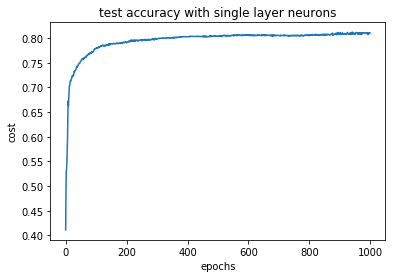

In [13]:
data_visualization = DataVisualization()
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

batch_size = 32
epochs = 1000

softmax_nn = SingleLayerSoftmax(train_x=train_x.as_matrix(), train_y=train_y)
softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)

cost_train, prediction_train, exec_time, list_exec_time = softmax_nn.get_train_result()
prediction_test = softmax_nn.get_test_result()
    
%matplotlib inline

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=prediction_test,
    x_label="epochs", y_label="cost",
    title="test accuracy with single layer neurons",
    figure_name="./image/classification/2/single_layers",
    labels=[]
)